Monkey Species Classification<br>
Autor: Jose Jesus Torronteras Hernández

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tqdm import tqdm
import os
import csv

from os import listdir, makedirs
from os.path import join

Using TensorFlow backend.


# Preprocess Data Image

In [2]:
# Keep only the first 10 classes
NUM_CLASSES = 10 

IMG_size = 150

data_dir = 'Dataset/'
train_dir = 'Dataset/training/'
val_dir = 'Dataset/validation/'

labels = pd.read_csv(join(data_dir, 'monkey_labels.txt'))
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [3]:
columns_new = ['Label', 'Latin_Name', 'Common_Name', 'Train_Images', 'Validation_Images']
labels.columns = columns_new
genres = [i.split() for i in labels.Common_Name.values]
genres

[['mantled_howler'],
 ['patas_monkey'],
 ['bald_uakari'],
 ['japanese_macaque'],
 ['pygmy_marmoset'],
 ['white_headed_capuchin'],
 ['silvery_marmoset'],
 ['common_squirrel_monkey'],
 ['black_headed_night_monkey'],
 ['nilgiri_langur']]

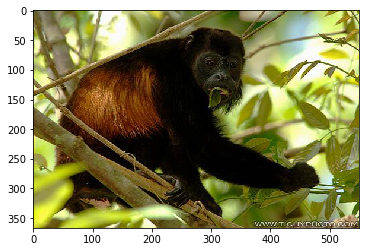

In [4]:
import matplotlib.image as mpimg
img = mpimg.imread(train_dir + 'n0/n0018.jpg')
imgplot = plt.imshow(img)
plt.show()

In [5]:
def preprocess_img(path, size):
    img = image.load_img(path, target_size=size)
    img = image.img_to_array(img)
    return img

(150, 150, 3)


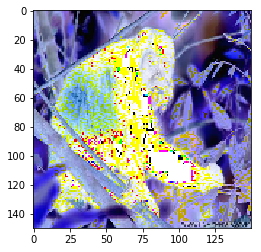

In [6]:
img = preprocess_img(train_dir + 'n0/n0018.jpg', (IMG_size,IMG_size))
print(img.shape)
plt.imshow(img, interpolation='nearest')
plt.show()

In [7]:
def generate_data(path):
    data_arr = []
    labels_arr = []

    for root, subdirs, images in os.walk(path):
        subdirs.sort() # Sort all subdirs
        labels_arr.append(len(images))
        for img in tqdm(images):
            if img.endswith('.jpg'):
                try:
                    file_Path = os.path.join(root, img)
                    np_image = preprocess_img(file_Path, (IMG_size,IMG_size))
                    x = xception.preprocess_input(np_image.copy())
                    data_arr.append(x)
                except Exception as e:
                    print("Error accured" + str(e))
            else:
                labels_arr[-1] = labels_arr[-1]-1 #File error
        
    labels = np.concatenate((np.zeros(labels_arr[1]),\
                        np.ones(labels_arr[2]),\
                        np.full(labels_arr[3], 2),\
                        np.full(labels_arr[4], 3),\
                        np.full(labels_arr[5], 4),\
                        np.full(labels_arr[6], 5),\
                        np.full(labels_arr[7], 6),\
                        np.full(labels_arr[8], 7),\
                        np.full(labels_arr[9], 8),\
                        np.full(labels_arr[10], 9)))
    
    return np.array(data_arr), labels

In [8]:
X_train, y_train = generate_data(train_dir)

100%|██████████| 107/107 [00:04<00:00, 22.60it/s]


In [9]:
X_test, y_test = generate_data(val_dir)

100%|██████████| 26/26 [00:01<00:00, 18.01it/s]


In [10]:
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(
            X_test,
            y_test,
            test_size = 0.5,
            random_state = 0,
            stratify = y_test)

In [11]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (1097, 150, 150, 3)
y_train:  (1097,)
X_test:  (136, 150, 150, 3)
y_test:  (136,)
X_val:  (136, 150, 150, 3)
y_val:  (136,)


# Defining model

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras import regularizers
from keras import backend as K
from keras.utils.vis_utils import plot_model

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
plot_model(model, to_file='assets/model_plot.png', show_shapes=True, show_layer_names=True)

<img src="assets/model_plot.png">

# Results
See Console-Log Results

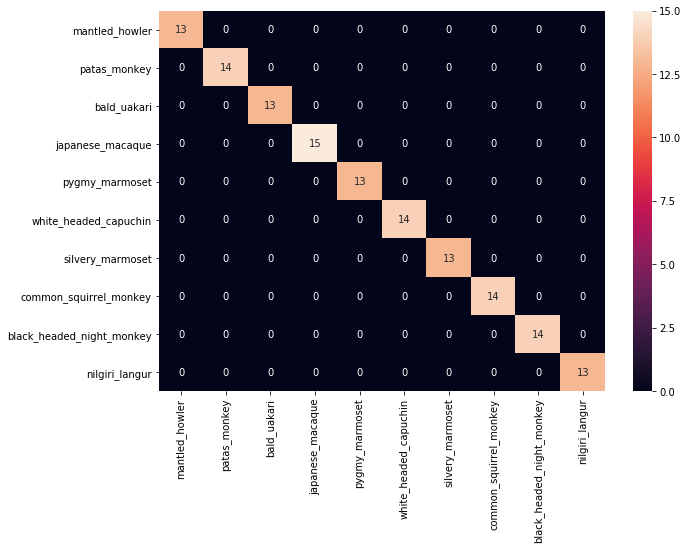

In [14]:
import seaborn as sn
array = [[13,0,0,0,0,0,0,0,0,0],
        [0,14,0,0,0,0,0,0,0,0],
        [0,0,13,0,0,0,0,0,0,0],
        [0,0,0,15,0,0,0,0,0,0],
        [0,0,0,0,13,0,0,0,0,0],
        [0,0,0,0,0,14,0,0,0,0],
        [0,0,0,0,0,0,13,0,0,0],
        [0,0,0,0,0,0,0,14,0,0],
        [0,0,0,0,0,0,0,0,14,0],
        [0,0,0,0,0,0,0,0,0,13]]

df_cm = pd.DataFrame(array, index = [i[0] for i in genres],
                  columns = [i[0] for i in genres])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()